# Introduction

These calculations assess the maximum retained height that can typically be attained using the various Stepoc block types.  In assessing the maximum height the calculations consider:

- The maximum height to satisfy serviceability limit state accounting for the lateral yield of the wall
- The maximum height to satisfy ultimate limit state based on a set of assumed soil parameters accounting for bending and shear

These calculations are for demonstration purposes only in establishing the maximum retained height. The acutal maximum retained height will depend on the actual soil and ground water condition, the magnitude of the surcharge and the geometry of the retained soil.

The calculations follow the principles of BS EN 1990.

## Ultimate limit state soil parameters assumed

- The Worst credible bulk unit weight of the soil $\gamma_b = 20 kN/m^3$
- Drain conditions for the soil with the design parameters $C' = 0$ and $\phi '= 32^{\circ}$
- An angle of wall friction $\delta = 20^{\circ}$ with a horizontal retained surface
- A nominal surcharge of $5kN/m^2$

Due to nominal yielding of the wall it will be assumed that full active conditions exist in the soil block behind the wall with a Rankine pressure distribution.

## Analysis of the wall section

The maximum bendding moment will be calculated using the derived equation in the Structensor repot *'A Proposal for Establishing the Maximum Bending Capacity of Stepoc'*. The calculation of ULS shear capacity is based on the recommendations within BS EN 1996-1-1 Annex J. The SLS state in this report is assumed complied with by limiting the span to effective depth ratio of the reinforced section to the limits presented in BS EN 1996-1-1 Table 5.2.

## Stepoc units considered

- Stepoc 200 with a wall thickness of 35mm and a 12mm diameter horizontal rebar central
- Stepoc 256 with a wall thickness of 39mm and a horizontal bar 152mm from the compressive face
- Stepoc 325 with a wall thickness of 39mm and a horizontal bar 186mm from the compressive face

In all cases, for the purposes of calculating the effective depth, a vertical rebar of 16mm diameter is assumed.

# SLS Calculations

Table 5.2 of BS EN 1996-1-1 places a limit of 18 on cantilevered reinforced masonry elements subject to out of plane bending. This limit leads to the following maximum heights for the stem of the retaining wall from the top of the supporting foundation:

In [81]:
names = ['Stepoc 200', 'Stepoc 256', 'Stepoc 325']
stepocd = [200/2, 152, 186] # Values in mm
max_sls_height = []
for i in range(len(stepocd)):
    h = 18 * stepocd[i]
    max_sls_height.append(h)
    print('Max SLS Stem height for ', names[i], ' = {:.2f}'.format(h))

Max SLS Stem height for  Stepoc 200  = 1800.00
Max SLS Stem height for  Stepoc 256  = 2736.00
Max SLS Stem height for  Stepoc 325  = 3348.00


# ULS Calculations
## Bending
The maximum bending capacity of Stepoc in the Structensor report is given by:

\begin{align}
M_{Rd} = b f_{md} \left(x_s (d - \frac{x_s}{2}) +  \alpha (x-x_s) (d - \frac{(x + x_s)}{2})\right)
\end{align}

Where to limit the depth of the compressive stress block the the following is assumed:

\begin{align}
x=d(1-\sqrt{0.20})
\end{align}

The value of the modular ratio is assumed to be $\alpha = 3$. The following functions provides the maximum moment capacity of the sections:

In [82]:
import pandas as pd
pd.set_option('precision', 3)
import math
xs = [35, 39, 39]
''' Set up data structure'''
moment_cap_data = pd.DataFrame({'d':stepocd, 'xs':xs})

''' Calculate the value of x'''
moment_cap_data['x'] = moment_cap_data['d'] * (1 - math.sqrt(0.20))

''' Calculate the moment capacity'''
a = 3
b = 1000
fmd = 9.92

moment_cap_data['Mcap'] = ((moment_cap_data['xs']*(moment_cap_data['d'] - moment_cap_data['xs']/2)
+ a * (moment_cap_data['x'] - moment_cap_data['xs']) * (moment_cap_data['d'] - (moment_cap_data['x'] + moment_cap_data['xs'])/2))
*b*fmd *10**-6)

display(moment_cap_data)

,d,xs,x,Mcap
0,100.0,35,55.279,61.752
1,152.0,39,84.024,172.507
2,186.0,39,102.818,283.000


## Shear
Within these calculations $\gamma_M$ for masonry is taken to be 2.0.

Annex J in BS EN 1996-1-1 provides the following equation for the shear strength of the section:

\begin{align}
f_{vd} = \frac{0.35 + 17.5 \rho}{\gamma_M}
\\\rho = \frac{A_s}{bd}
\end{align}

Providing that $f_{vd}$ is not taken to be greater than $\frac{0.70}{\gamma_M}$.

$f_{vd}$ may be enhanced by the following factor:

\begin{align}
\chi = (2.5 - 0.25 \frac{a_v}{d})
\end{align}

Where $a_v$ is the shear span of the section (max bending moment / max shear force in the section).

In order to use the above equation an area of steel needs to be established. This can be achieved by using by provding equalibrium of the section with the following equations for the force in the compressive stress blocks:

\begin{align}
\text{In the masonry: }
F_m = \frac{b x_s f_{md}}{\gamma_{Mm}}\\
\text{In the concrete: }
F_c = \frac{b (x - x_s)f_{cd}}{\gamma_{Mc}}\\
\text{In total: } F_t = F_m + F_c
\end{align}

From this we can assume that $A_s f_y / \gamma_M = F_t$ to give $A_s = F_t / (0.87 f_y)$.

These calculations can be added to the data set:

In [83]:
moment_cap_data['Fm'] = b * moment_cap_data['xs'] * fmd * 10**-3 / 2
moment_cap_data['Fc'] = b * (moment_cap_data['x'] - moment_cap_data['xs']) * a * fmd * 10**-3 / 1.5
moment_cap_data['Ft'] = (moment_cap_data['Fm']+moment_cap_data['Fc'])
moment_cap_data['As'] = moment_cap_data['Ft'] * 10**3 / (0.87 * 500)
moment_cap_data['p'] = moment_cap_data['As'] / (b * moment_cap_data['d'])
moment_cap_data['fvd'] = (0.35 + 17.5 * moment_cap_data.p / 2)
moment_cap_data['fvdmax'] = 0.70 / 2
moment_cap_data['Shear Cap'] = moment_cap_data.fvdmax * b * moment_cap_data.d * 10**-3
display(moment_cap_data)

,d,xs,x,Mcap,Fm,Fc,Ft,As,p,fvd,fvdmax,Shear Cap
0,100.0,35,55.279,61.752,173.60,402.328,575.928,1323.973,0.013,0.466,0.35,35.0
1,152.0,39,84.024,172.507,193.44,893.267,1086.707,2498.177,0.016,0.494,0.35,53.2
2,186.0,39,102.818,283.000,193.44,1266.155,1459.595,3355.390,0.018,0.508,0.35,65.1


We can conclude from the above that it is possible to provide sufficient reinforcement to balance the limited compressive stress block such that the maximum limit of $f_{vd}$ may be used in maximum value calculations.

# Force effects on retaining walls
The active pressure coefficient for a granular soil is
calculated from the formula:

\begin{align}
k_a = \left(\frac{cosec(\psi) sin(\psi - \phi)}{\sqrt{sin(\psi - \delta)}
+ \sqrt{\frac{sin(\phi+\delta) sin(\phi - \beta)}{sin(\psi-\beta)}}}\right)^2
\end{align}

Where:

- $\psi$ is the angle of the back of the wall from the horizontal
- $\phi$ is the internal angle of friction for the soil
- $\delta$ is the angle of frction to the back of the wall
- $\beta$ is the angle of the retained soil surface from the horizontal

## Force effects on the retaining wall
Pressure at a depth $z$ below is given by:
\begin{align}
p_a = k_a(\gamma_{fe} z \gamma_s + \gamma_{fq} q)
\end{align}

Where:

- $\gamma_{fe}$ is the partial factor applied to earth unit force density
- $\gamma_{fq}$ is the partial factor applied to the surcharge
- $\gamma_s$ is the earth force density
- $q$ surcharge applied to the retained surface

From the above:
\begin{align}
&V = \int_0^z k_a(\gamma_{fe} z \gamma_s + \gamma_{fq} q) cos(\delta) dz\\
&V = k_a(\frac{\gamma_{fe} \gamma_{s} z^2}{2} + \gamma_{fq}qz)cos(\delta)
\end{align}

V = shear force at depth z perpendicular to the back of the wall.

And moments $M$:
\begin{align}
&M = \int_0^zk_a \left(\frac{\gamma_{fe} \gamma_{s} z^2}{2} + \gamma_{fq}qz \right)cos(\delta)dz\\
&M = k_a\left(\frac{\gamma_{fe} \gamma_{s} z^3}{6} + \frac{\gamma_{fq}qz^2}{2} \right)cos(\delta)
\end{align}

The shear applied over the plane of the back of the $F_v$ wall (or virtual back) is:
\begin{align}
F_v = V sin(\delta)
\end{align}

These equations are encoded in the methods below.

In [84]:
import math

def ka(psi, phi, delta, beta):
    # convert to radians
    psi = math.radians(psi)
    phi = math.radians(phi)
    delta = math.radians(delta)
    beta = math.radians(beta)
    a = math.sin(psi - phi) / math.sin(psi)
    b = math.sqrt(math.sin(psi - delta))
    c = math.sqrt(math.sin(phi + delta) * math.sin(phi - beta)
                  / math.sin(psi - beta))
    ka = (a / (b + c))**2
    return ka
def p(ka, z, gs, gfe, gfq, q):
    return ka*(gfe * gs * z + gfq * q)
def V(ka, delta, z, gs, gfe, gfq, q):
    delta = math.radians(delta)
    earth = gfe * gs * z**2/2
    surcharge = gfq * q * z
    return math.cos(delta) * ka * (earth + surcharge)

def M(ka, delta, z, gs, gfe, gfq, q):
    delta = math.radians(delta)
    earth = gfe * gs * z**3 / 6
    surcharge = gfq * q * z**2 / 2
    return ka * math.cos(delta)*(earth + surcharge)

Establish the input paramneters to use the above functions:

In [85]:
'''Input data from ultimate limit state soil parameters'''
soil_weight = 20
wall_friction = 20
soil_friction = 32
surcharge = 5
gfe = 1.35
gfq = 1.50
k_active = ka(90, soil_friction, wall_friction, 0)

## Establish the value of shear enhancement factor ($\chi$)

Plot the shear strength enhancement factor as a function of depth and layer over that the maximum stem heights calculated for SLS above.

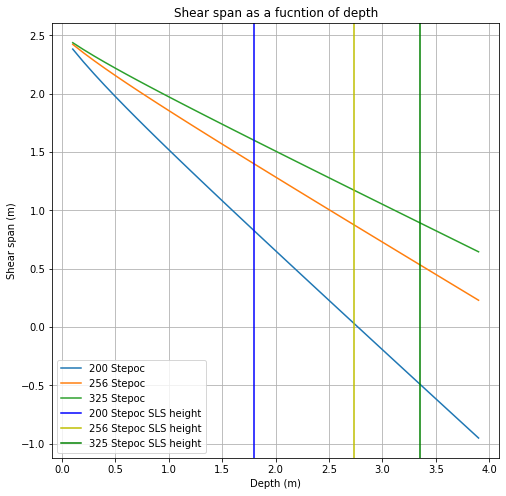

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
'''Plot the shear strength enhancement factors over depth'''
plt.figure(figsize=(8,8))
x = np.arange(0,4,0.10)
va = V(k_active, wall_friction, x, soil_weight, gfe, gfq, surcharge)
ma = M(k_active, wall_friction, x, soil_weight, gfe, gfq, surcharge)
av = ma/va
plt.plot(x, (2.50 - 0.25 * (av * 1000 / stepocd[0])), label='200 Stepoc')
plt.plot(x, (2.50 - 0.25 * (av * 1000 / stepocd[1])), label='256 Stepoc')
plt.plot(x, (2.50 - 0.25 * (av * 1000 / stepocd[2])), label='325 Stepoc')
plt.axvline(max_sls_height[0]/1000, label='200 Stepoc SLS height', color='b')
plt.axvline(max_sls_height[1]/1000, label='256 Stepoc SLS height', color='y')
plt.axvline(max_sls_height[2]/1000, label='325 Stepoc SLS height', color='g')
plt.xlabel('Depth (m)')
plt.ylabel('Shear span (m)')
plt.title('Shear span as a fucntion of depth')
plt.legend()
plt.grid()
plt.show()

The above plots demonstrate that in the vincinty of the maximum SLS height the shear strength ehancement factor is less than 1. It is therefore ignoed in shear strength plots below.

## Retaining wall foce effects plot with Stepoc capacities layered over

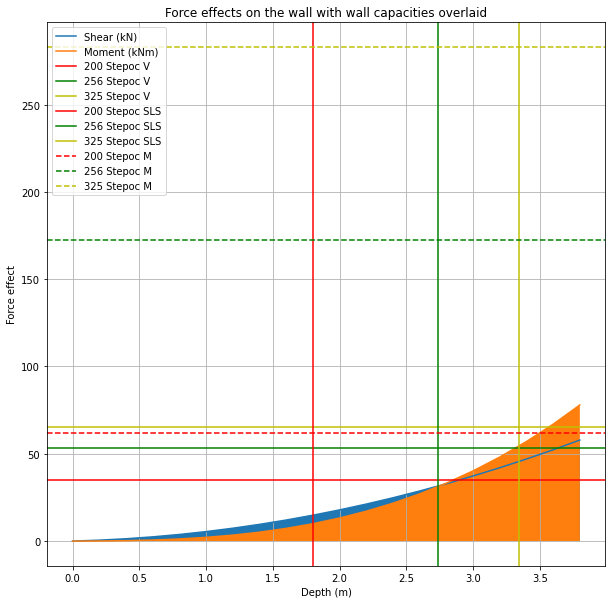

In [87]:
'''Graphical plot of force effects'''
plt.figure(figsize=(10,10))
x = np.arange(0,4,0.20)
va = V(k_active, wall_friction, x, soil_weight, gfe, gfq, surcharge)
ma = M(k_active, wall_friction, x, soil_weight, gfe, gfq, surcharge)
plt.plot(x, va, label='Shear (kN)')
plt.fill_between(x, va)
plt.plot(x, ma, label='Moment (kNm)')
plt.fill_between(x, ma)
plt.axhline(moment_cap_data.iloc[0,11], label='200 Stepoc V', color='r')
plt.axhline(moment_cap_data.iloc[1,11], label='256 Stepoc V', color='g')
plt.axhline(moment_cap_data.iloc[2,11], label='325 Stepoc V', color='y')
plt.axvline(max_sls_height[0]/1000, label='200 Stepoc SLS', color='r')
plt.axvline(max_sls_height[1]/1000, label = '256 Stepoc SLS', color='g')
plt.axvline(max_sls_height[2]/1000, label = '325 Stepoc SLS', color='y')
plt.axhline(moment_cap_data.iloc[0,3], label='200 Stepoc M', color='r', linestyle='--')
plt.axhline(moment_cap_data.iloc[1,3], label='256 Stepoc M', color='g', linestyle='--')
plt.axhline(moment_cap_data.iloc[2,3], label='325 Stepoc M', color='y', linestyle='--')
plt.grid()
plt.title('Force effects on the wall with wall capacities overlaid')
plt.legend()
plt.xlabel('Depth (m)')
plt.ylabel('Force effect')
plt.show()

The above capacity plots demonstrate that in all cases the limiting SLS conditon from BS EN 1996-1-1 (Table 5.1) governs the maximum retaining wall stem height under the conditions assumed.

# Conclusions

The calculations within this report, for the soil conditions assumed, demonstrate that the deemed to satisfy serviceability limit state governs the maximum retained height for the stem.

Under the conditions within this report, being typical of drained retaining wall conditions with nominal surcharge the following are the maximum retained heights:

- 200 Stepoc max height = 1.80 m
- 256 Stepoc max hieght = 2.70 m
- 325 Stepoc max height = 3.30 m

